# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (SentiWS) most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, SentiWS (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11753
EM converged at iteration 58, llf=-11509, convergence criterion=9.933e-07 < tolerance=1e-06
EM start iterations, llf=-11766
EM converged at iteration 58, llf=-11521, convergence criterion=9.9246e-07 < tolerance=1e-06
EM start iterations, llf=-11819
EM converged at iteration 58, llf=-11572, convergence criterion=9.9063e-07 < tolerance=1e-06
EM start iterations, llf=-11826
EM converged at iteration 58, llf=-11579, convergence criterion=9.9057e-07 < tolerance=1e-06
EM start iterations, llf=-11892
EM converged at iteration 59, llf=-11640, convergence criterion=9.6888e-07 < tolerance=1e-06
EM start iterations, llf=-11900
EM converged at iteration 59, llf=-11647, convergence criterion=9.6552e-07 < tolerance=1e-06
EM start iterations, llf=-11955
EM converged at iteration 58, llf=-11703, convergence criterion=9.9919e-07 < tolerance=1e-06
EM start iterations, llf=-11955
EM converged at iteration 58, llf=-11703, convergence criterion=9.9919e-07 < tolerance=1e-06
E

EM start iterations, llf=-13490
EM converged at iteration 48, llf=-13292, convergence criterion=9.8455e-07 < tolerance=1e-06
EM start iterations, llf=-13551
EM converged at iteration 47, llf=-13364, convergence criterion=9.5837e-07 < tolerance=1e-06
EM start iterations, llf=-13556
EM converged at iteration 47, llf=-13367, convergence criterion=9.6234e-07 < tolerance=1e-06
EM start iterations, llf=-13607
EM converged at iteration 47, llf=-13413, convergence criterion=9.6343e-07 < tolerance=1e-06
EM start iterations, llf=-13607
EM converged at iteration 47, llf=-13413, convergence criterion=9.6343e-07 < tolerance=1e-06
EM start iterations, llf=-13619
EM converged at iteration 47, llf=-13426, convergence criterion=9.7325e-07 < tolerance=1e-06
EM start iterations, llf=-13668
EM converged at iteration 47, llf=-13477, convergence criterion=9.738e-07 < tolerance=1e-06
EM start iterations, llf=-13673
EM converged at iteration 47, llf=-13481, convergence criterion=9.7381e-07 < tolerance=1e-06
E

EM start iterations, llf=-15230
EM converged at iteration 48, llf=-15020, convergence criterion=9.8803e-07 < tolerance=1e-06
EM start iterations, llf=-15230
EM converged at iteration 48, llf=-15020, convergence criterion=9.8803e-07 < tolerance=1e-06
EM start iterations, llf=-15239
EM converged at iteration 48, llf=-15029, convergence criterion=9.8729e-07 < tolerance=1e-06
EM start iterations, llf=-15292
EM converged at iteration 48, llf=-15082, convergence criterion=9.8367e-07 < tolerance=1e-06
EM start iterations, llf=-15303
EM converged at iteration 48, llf=-15093, convergence criterion=9.8073e-07 < tolerance=1e-06
EM start iterations, llf=-15352
EM converged at iteration 48, llf=-15142, convergence criterion=9.9075e-07 < tolerance=1e-06
EM start iterations, llf=-15360
EM converged at iteration 48, llf=-15149, convergence criterion=9.886e-07 < tolerance=1e-06
EM start iterations, llf=-15406
EM converged at iteration 48, llf=-15193, convergence criterion=9.8376e-07 < tolerance=1e-06
E

EM start iterations, llf=-16937
EM converged at iteration 58, llf=-16692, convergence criterion=9.6749e-07 < tolerance=1e-06
EM start iterations, llf=-16942
EM converged at iteration 58, llf=-16697, convergence criterion=9.675e-07 < tolerance=1e-06
EM start iterations, llf=-16997
EM converged at iteration 58, llf=-16752, convergence criterion=9.7866e-07 < tolerance=1e-06
EM start iterations, llf=-17004
EM converged at iteration 58, llf=-16758, convergence criterion=9.789e-07 < tolerance=1e-06
EM start iterations, llf=-17060
EM converged at iteration 58, llf=-16816, convergence criterion=9.7536e-07 < tolerance=1e-06
EM start iterations, llf=-17060
EM converged at iteration 58, llf=-16816, convergence criterion=9.7536e-07 < tolerance=1e-06
EM start iterations, llf=-17069
EM converged at iteration 58, llf=-16825, convergence criterion=9.7355e-07 < tolerance=1e-06
EM start iterations, llf=-17121
EM converged at iteration 58, llf=-16876, convergence criterion=9.6953e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18462
EM converged at iteration 58, llf=-18204, convergence criterion=9.7416e-07 < tolerance=1e-06
EM start iterations, llf=-18520
EM converged at iteration 58, llf=-18260, convergence criterion=9.7084e-07 < tolerance=1e-06
EM start iterations, llf=-18520
EM converged at iteration 58, llf=-18260, convergence criterion=9.7084e-07 < tolerance=1e-06
EM start iterations, llf=-18525
EM converged at iteration 58, llf=-18265, convergence criterion=9.7073e-07 < tolerance=1e-06
EM start iterations, llf=-18578
EM converged at iteration 58, llf=-18316, convergence criterion=9.6852e-07 < tolerance=1e-06
EM start iterations, llf=-18584
EM converged at iteration 58, llf=-18323, convergence criterion=9.6799e-07 < tolerance=1e-06
EM start iterations, llf=-18640
EM converged at iteration 58, llf=-18378, convergence criterion=9.7332e-07 < tolerance=1e-06
EM start iterations, llf=-18648
EM converged at iteration 58, llf=-18386, convergence criterion=9.7315e-07 < tolerance=1e-06


EM start iterations, llf=-12311
EM converged at iteration 59, llf=-12041, convergence criterion=9.7209e-07 < tolerance=1e-06
EM start iterations, llf=-12293
EM converged at iteration 59, llf=-12021, convergence criterion=9.6816e-07 < tolerance=1e-06
EM start iterations, llf=-12352
EM converged at iteration 59, llf=-12093, convergence criterion=9.7179e-07 < tolerance=1e-06
EM start iterations, llf=-12371
EM converged at iteration 59, llf=-12118, convergence criterion=9.6607e-07 < tolerance=1e-06
EM start iterations, llf=-12438
EM converged at iteration 59, llf=-12205, convergence criterion=9.8832e-07 < tolerance=1e-06
EM start iterations, llf=-12436
EM converged at iteration 59, llf=-12202, convergence criterion=9.8021e-07 < tolerance=1e-06
EM start iterations, llf=-12456
EM converged at iteration 57, llf=-12229, convergence criterion=9.9335e-07 < tolerance=1e-06
EM start iterations, llf=-12456
EM converged at iteration 57, llf=-12229, convergence criterion=9.9335e-07 < tolerance=1e-06


EM start iterations, llf=-14033
EM converged at iteration 53, llf=-13826, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-14073
EM converged at iteration 53, llf=-13858, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-14078
EM converged at iteration 54, llf=-13870, convergence criterion=9.7378e-07 < tolerance=1e-06
EM start iterations, llf=-14128
EM converged at iteration 56, llf=-13927, convergence criterion=9.7104e-07 < tolerance=1e-06
EM start iterations, llf=-14128
EM converged at iteration 56, llf=-13927, convergence criterion=9.7104e-07 < tolerance=1e-06
EM start iterations, llf=-14139
EM converged at iteration 56, llf=-13938, convergence criterion=9.7414e-07 < tolerance=1e-06
EM start iterations, llf=-14192
EM converged at iteration 56, llf=-13990, convergence criterion=9.6278e-07 < tolerance=1e-06
EM start iterations, llf=-14199
EM converged at iteration 55, llf=-13996, convergence criterion=9.8294e-07 < tolerance=1e-06


EM start iterations, llf=-15782
EM converged at iteration 53, llf=-15557, convergence criterion=9.9852e-07 < tolerance=1e-06
EM start iterations, llf=-15782
EM converged at iteration 53, llf=-15557, convergence criterion=9.9852e-07 < tolerance=1e-06
EM start iterations, llf=-15790
EM converged at iteration 53, llf=-15565, convergence criterion=9.8516e-07 < tolerance=1e-06
EM start iterations, llf=-15843
EM converged at iteration 53, llf=-15616, convergence criterion=9.8306e-07 < tolerance=1e-06
EM start iterations, llf=-15845
EM converged at iteration 53, llf=-15617, convergence criterion=9.8639e-07 < tolerance=1e-06
EM start iterations, llf=-15902
EM converged at iteration 54, llf=-15673, convergence criterion=9.6847e-07 < tolerance=1e-06
EM start iterations, llf=-15906
EM converged at iteration 54, llf=-15677, convergence criterion=9.6627e-07 < tolerance=1e-06
EM start iterations, llf=-15952
EM converged at iteration 54, llf=-15722, convergence criterion=9.6986e-07 < tolerance=1e-06


EM start iterations, llf=-17496
EM converged at iteration 62, llf=-17255, convergence criterion=9.9317e-07 < tolerance=1e-06
EM start iterations, llf=-17502
EM converged at iteration 62, llf=-17260, convergence criterion=9.9232e-07 < tolerance=1e-06
EM start iterations, llf=-17555
EM converged at iteration 62, llf=-17312, convergence criterion=9.9753e-07 < tolerance=1e-06
EM start iterations, llf=-17563
EM converged at iteration 62, llf=-17319, convergence criterion=9.9411e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 62, llf=-17366, convergence criterion=9.9192e-07 < tolerance=1e-06
EM start iterations, llf=-17611
EM converged at iteration 62, llf=-17366, convergence criterion=9.9192e-07 < tolerance=1e-06
EM start iterations, llf=-17630
EM converged at iteration 62, llf=-17386, convergence criterion=9.9204e-07 < tolerance=1e-06
EM start iterations, llf=-17683
EM converged at iteration 62, llf=-17439, convergence criterion=9.82e-07 < tolerance=1e-06
EM

EM start iterations, llf=-19012
EM converged at iteration 61, llf=-18738, convergence criterion=9.9388e-07 < tolerance=1e-06
EM start iterations, llf=-19061
EM converged at iteration 61, llf=-18789, convergence criterion=9.8894e-07 < tolerance=1e-06
EM start iterations, llf=-19061
EM converged at iteration 61, llf=-18789, convergence criterion=9.8894e-07 < tolerance=1e-06
EM start iterations, llf=-19069
EM converged at iteration 61, llf=-18798, convergence criterion=9.8983e-07 < tolerance=1e-06
EM start iterations, llf=-19126
EM converged at iteration 61, llf=-18855, convergence criterion=9.889e-07 < tolerance=1e-06
EM start iterations, llf=-19134
EM converged at iteration 61, llf=-18863, convergence criterion=9.8807e-07 < tolerance=1e-06
EM start iterations, llf=-19187
EM converged at iteration 61, llf=-18914, convergence criterion=9.7126e-07 < tolerance=1e-06
EM start iterations, llf=-19196
EM converged at iteration 61, llf=-18922, convergence criterion=9.6998e-07 < tolerance=1e-06
E

EM start iterations, llf=-12811
EM converged at iteration 61, llf=-12594, convergence criterion=9.8458e-07 < tolerance=1e-06
EM start iterations, llf=-12817
EM converged at iteration 61, llf=-12601, convergence criterion=9.8375e-07 < tolerance=1e-06
EM start iterations, llf=-12866
EM converged at iteration 60, llf=-12647, convergence criterion=9.9395e-07 < tolerance=1e-06
EM start iterations, llf=-12873
EM converged at iteration 60, llf=-12655, convergence criterion=9.9424e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM converged at iteration 57, llf=-12691, convergence criterion=9.9324e-07 < tolerance=1e-06
EM start iterations, llf=-12926
EM converged at iteration 57, llf=-12701, convergence criterion=9.8698e-07 < tolerance=1e-06
EM start iterations, llf=-12987
EM converged at iteration 58, llf=-12770, convergence criterion=9.855e-07 < tolerance=1e-06
EM start iterations, llf=-12987
EM converged at iteration 58, llf=-12770, convergence criterion=9.855e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14550
EM converged at iteration 59, llf=-14346, convergence criterion=9.9386e-07 < tolerance=1e-06
EM start iterations, llf=-14609
EM converged at iteration 60, llf=-14409, convergence criterion=9.7514e-07 < tolerance=1e-06
EM start iterations, llf=-14618
EM converged at iteration 59, llf=-14414, convergence criterion=9.9967e-07 < tolerance=1e-06
EM start iterations, llf=-14673
EM converged at iteration 60, llf=-14470, convergence criterion=9.742e-07 < tolerance=1e-06
EM start iterations, llf=-14673
EM converged at iteration 60, llf=-14470, convergence criterion=9.742e-07 < tolerance=1e-06
EM start iterations, llf=-14681
EM converged at iteration 60, llf=-14477, convergence criterion=9.6539e-07 < tolerance=1e-06
EM start iterations, llf=-14736
EM converged at iteration 59, llf=-14531, convergence criterion=9.954e-07 < tolerance=1e-06
EM start iterations, llf=-14744
EM converged at iteration 59, llf=-14538, convergence criterion=9.7934e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16316
EM converged at iteration 57, llf=-16088, convergence criterion=9.9954e-07 < tolerance=1e-06
EM start iterations, llf=-16316
EM converged at iteration 57, llf=-16088, convergence criterion=9.9954e-07 < tolerance=1e-06
EM start iterations, llf=-16325
EM converged at iteration 57, llf=-16096, convergence criterion=9.9725e-07 < tolerance=1e-06
EM start iterations, llf=-16379
EM converged at iteration 57, llf=-16149, convergence criterion=9.9086e-07 < tolerance=1e-06
EM start iterations, llf=-16388
EM converged at iteration 57, llf=-16158, convergence criterion=9.8903e-07 < tolerance=1e-06
EM start iterations, llf=-16438
EM converged at iteration 57, llf=-16208, convergence criterion=9.8514e-07 < tolerance=1e-06
EM start iterations, llf=-16446
EM converged at iteration 57, llf=-16215, convergence criterion=9.8213e-07 < tolerance=1e-06
EM start iterations, llf=-16498
EM converged at iteration 57, llf=-16266, convergence criterion=9.7757e-07 < tolerance=1e-06


EM start iterations, llf=-18025
EM converged at iteration 64, llf=-17777, convergence criterion=9.9165e-07 < tolerance=1e-06
EM start iterations, llf=-18031
EM converged at iteration 64, llf=-17785, convergence criterion=9.9245e-07 < tolerance=1e-06
EM start iterations, llf=-18084
EM converged at iteration 64, llf=-17836, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-18091
EM converged at iteration 64, llf=-17843, convergence criterion=9.8911e-07 < tolerance=1e-06
EM start iterations, llf=-18147
EM converged at iteration 64, llf=-17898, convergence criterion=9.8757e-07 < tolerance=1e-06
EM start iterations, llf=-18147
EM converged at iteration 64, llf=-17898, convergence criterion=9.8757e-07 < tolerance=1e-06
EM start iterations, llf=-18151
EM converged at iteration 64, llf=-17900, convergence criterion=9.854e-07 < tolerance=1e-06
EM start iterations, llf=-18202
EM converged at iteration 64, llf=-17950, convergence criterion=9.8206e-07 < tolerance=1e-06
E

EM start iterations, llf=-19266
EM converged at iteration 65, llf=-18990, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-19320
EM converged at iteration 65, llf=-19043, convergence criterion=9.8596e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:09:02.884058.
EM start iterations, llf=-11278
EM converged at iteration 57, llf=-11134, convergence criterion=9.6644e-07 < tolerance=1e-06
EM start iterations, llf=-11291
EM converged at iteration 56, llf=-11146, convergence criterion=9.9819e-07 < tolerance=1e-06
EM start iterations, llf=-11342
EM converged at iteration 56, llf=-11198, convergence criterion=9.8667e-07 < tolerance=1e-06
EM start iterations, llf=-11350
EM converged at iteration 56, llf=-11206, convergence criterion=9.8437e-07 < tolerance=1e-06
EM start iterations, llf=-11410
EM converged at iteration 55, llf=-11266, convergence criterion=9.7487e-07 < tolerance=1e-06
EM start iterations, llf=-11420
EM converged at

EM start iterations, llf=-12775
EM converged at iteration 50, llf=-12625, convergence criterion=9.6619e-07 < tolerance=1e-06
EM start iterations, llf=-12788
EM converged at iteration 50, llf=-12638, convergence criterion=9.6744e-07 < tolerance=1e-06
EM start iterations, llf=-12824
EM converged at iteration 50, llf=-12672, convergence criterion=9.6275e-07 < tolerance=1e-06
EM start iterations, llf=-12831
EM converged at iteration 50, llf=-12677, convergence criterion=9.6317e-07 < tolerance=1e-06
EM start iterations, llf=-12888
EM converged at iteration 48, llf=-12728, convergence criterion=9.712e-07 < tolerance=1e-06
EM start iterations, llf=-12893
EM converged at iteration 48, llf=-12735, convergence criterion=9.6782e-07 < tolerance=1e-06
EM start iterations, llf=-12933
EM converged at iteration 47, llf=-12775, convergence criterion=9.863e-07 < tolerance=1e-06
EM start iterations, llf=-12933
EM converged at iteration 47, llf=-12775, convergence criterion=9.863e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14393
EM converged at iteration 45, llf=-14229, convergence criterion=9.9562e-07 < tolerance=1e-06
EM start iterations, llf=-14447
EM converged at iteration 47, llf=-14283, convergence criterion=9.9441e-07 < tolerance=1e-06
EM start iterations, llf=-14455
EM converged at iteration 47, llf=-14290, convergence criterion=9.942e-07 < tolerance=1e-06
EM start iterations, llf=-14504
EM converged at iteration 47, llf=-14340, convergence criterion=9.8714e-07 < tolerance=1e-06
EM start iterations, llf=-14504
EM converged at iteration 47, llf=-14340, convergence criterion=9.8714e-07 < tolerance=1e-06
EM start iterations, llf=-14511
EM converged at iteration 47, llf=-14348, convergence criterion=9.8706e-07 < tolerance=1e-06
EM start iterations, llf=-14562
EM converged at iteration 47, llf=-14398, convergence criterion=9.8067e-07 < tolerance=1e-06
EM start iterations, llf=-14569
EM converged at iteration 47, llf=-14405, convergence criterion=9.7922e-07 < tolerance=1e-06
E

EM start iterations, llf=-16086
EM converged at iteration 59, llf=-15911, convergence criterion=9.7038e-07 < tolerance=1e-06
EM start iterations, llf=-16086
EM converged at iteration 59, llf=-15911, convergence criterion=9.7038e-07 < tolerance=1e-06
EM start iterations, llf=-16099
EM converged at iteration 59, llf=-15925, convergence criterion=9.6905e-07 < tolerance=1e-06
EM start iterations, llf=-16156
EM converged at iteration 59, llf=-15982, convergence criterion=9.7057e-07 < tolerance=1e-06
EM start iterations, llf=-16158
EM converged at iteration 58, llf=-15985, convergence criterion=9.778e-07 < tolerance=1e-06
EM start iterations, llf=-16212
EM converged at iteration 59, llf=-16039, convergence criterion=9.7762e-07 < tolerance=1e-06
EM start iterations, llf=-16219
EM converged at iteration 59, llf=-16046, convergence criterion=9.7737e-07 < tolerance=1e-06
EM start iterations, llf=-16272
EM converged at iteration 59, llf=-16099, convergence criterion=9.768e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17537
EM converged at iteration 59, llf=-17358, convergence criterion=9.9306e-07 < tolerance=1e-06
EM start iterations, llf=-17551
EM converged at iteration 59, llf=-17371, convergence criterion=9.8496e-07 < tolerance=1e-06
EM start iterations, llf=-17608
EM converged at iteration 59, llf=-17427, convergence criterion=9.8755e-07 < tolerance=1e-06
EM start iterations, llf=-17614
EM converged at iteration 59, llf=-17432, convergence criterion=9.899e-07 < tolerance=1e-06
EM start iterations, llf=-17668
EM converged at iteration 59, llf=-17487, convergence criterion=9.8195e-07 < tolerance=1e-06
EM start iterations, llf=-17668
EM converged at iteration 59, llf=-17487, convergence criterion=9.8195e-07 < tolerance=1e-06
EM start iterations, llf=-17673
EM converged at iteration 59, llf=-17492, convergence criterion=9.8473e-07 < tolerance=1e-06
EM start iterations, llf=-17722
EM converged at iteration 59, llf=-17541, convergence criterion=9.7795e-07 < tolerance=1e-06
E

EM start iterations, llf=-11731
EM converged at iteration 67, llf=-11583, convergence criterion=9.8553e-07 < tolerance=1e-06
EM start iterations, llf=-11734
EM converged at iteration 66, llf=-11584, convergence criterion=9.8392e-07 < tolerance=1e-06
EM start iterations, llf=-11800
EM converged at iteration 62, llf=-11651, convergence criterion=9.9997e-07 < tolerance=1e-06
EM start iterations, llf=-11800
EM converged at iteration 62, llf=-11651, convergence criterion=9.9997e-07 < tolerance=1e-06
EM start iterations, llf=-11812
EM converged at iteration 63, llf=-11665, convergence criterion=9.9953e-07 < tolerance=1e-06
EM start iterations, llf=-11883
EM converged at iteration 62, llf=-11741, convergence criterion=9.9967e-07 < tolerance=1e-06
EM start iterations, llf=-11870
EM converged at iteration 62, llf=-11727, convergence criterion=9.9721e-07 < tolerance=1e-06
EM start iterations, llf=-11891
EM converged at iteration 62, llf=-11740, convergence criterion=9.7228e-07 < tolerance=1e-06


EM start iterations, llf=-13279
EM converged at iteration 56, llf=-13115, convergence criterion=9.9596e-07 < tolerance=1e-06
EM start iterations, llf=-13287
EM converged at iteration 56, llf=-13126, convergence criterion=9.8247e-07 < tolerance=1e-06
EM start iterations, llf=-13334
EM converged at iteration 56, llf=-13172, convergence criterion=9.9617e-07 < tolerance=1e-06
EM start iterations, llf=-13342
EM converged at iteration 56, llf=-13180, convergence criterion=9.9275e-07 < tolerance=1e-06
EM start iterations, llf=-13388
EM converged at iteration 57, llf=-13225, convergence criterion=9.6916e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM converged at iteration 56, llf=-13222, convergence criterion=9.987e-07 < tolerance=1e-06
EM start iterations, llf=-13426
EM converged at iteration 57, llf=-13266, convergence criterion=9.8188e-07 < tolerance=1e-06
EM start iterations, llf=-13426
EM converged at iteration 57, llf=-13266, convergence criterion=9.8188e-07 < tolerance=1e-06
E

EM start iterations, llf=-14921
EM converged at iteration 53, llf=-14755, convergence criterion=9.821e-07 < tolerance=1e-06
EM start iterations, llf=-14974
EM converged at iteration 52, llf=-14809, convergence criterion=9.8696e-07 < tolerance=1e-06
EM start iterations, llf=-14981
EM converged at iteration 52, llf=-14815, convergence criterion=9.9049e-07 < tolerance=1e-06
EM start iterations, llf=-15026
EM converged at iteration 52, llf=-14862, convergence criterion=9.8663e-07 < tolerance=1e-06
EM start iterations, llf=-15026
EM converged at iteration 52, llf=-14862, convergence criterion=9.8663e-07 < tolerance=1e-06
EM start iterations, llf=-15039
EM converged at iteration 52, llf=-14874, convergence criterion=9.8371e-07 < tolerance=1e-06
EM start iterations, llf=-15094
EM converged at iteration 52, llf=-14927, convergence criterion=9.8718e-07 < tolerance=1e-06
EM start iterations, llf=-15093
EM converged at iteration 52, llf=-14928, convergence criterion=9.8125e-07 < tolerance=1e-06
E

EM start iterations, llf=-16616
EM converged at iteration 63, llf=-16439, convergence criterion=9.9668e-07 < tolerance=1e-06
EM start iterations, llf=-16616
EM converged at iteration 63, llf=-16439, convergence criterion=9.9668e-07 < tolerance=1e-06
EM start iterations, llf=-16626
EM converged at iteration 63, llf=-16447, convergence criterion=9.9874e-07 < tolerance=1e-06
EM start iterations, llf=-16674
EM converged at iteration 64, llf=-16495, convergence criterion=9.9429e-07 < tolerance=1e-06
EM start iterations, llf=-16678
EM converged at iteration 64, llf=-16499, convergence criterion=9.9416e-07 < tolerance=1e-06
EM start iterations, llf=-16731
EM converged at iteration 65, llf=-16553, convergence criterion=9.8043e-07 < tolerance=1e-06
EM start iterations, llf=-16740
EM converged at iteration 65, llf=-16562, convergence criterion=9.7928e-07 < tolerance=1e-06
EM start iterations, llf=-16784
EM converged at iteration 65, llf=-16606, convergence criterion=9.8176e-07 < tolerance=1e-06


EM start iterations, llf=-18071
EM converged at iteration 64, llf=-17887, convergence criterion=9.8448e-07 < tolerance=1e-06
EM start iterations, llf=-18079
EM converged at iteration 64, llf=-17894, convergence criterion=9.8289e-07 < tolerance=1e-06
EM start iterations, llf=-18128
EM converged at iteration 64, llf=-17944, convergence criterion=9.8712e-07 < tolerance=1e-06
EM start iterations, llf=-18135
EM converged at iteration 64, llf=-17950, convergence criterion=9.8378e-07 < tolerance=1e-06
EM start iterations, llf=-18181
EM converged at iteration 64, llf=-17996, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-18181
EM converged at iteration 64, llf=-17996, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-18186
EM converged at iteration 64, llf=-18000, convergence criterion=9.8358e-07 < tolerance=1e-06
EM start iterations, llf=-18242
EM converged at iteration 64, llf=-18055, convergence criterion=9.7896e-07 < tolerance=1e-06


EM start iterations, llf=-12166
EM converged at iteration 72, llf=-12013, convergence criterion=9.7851e-07 < tolerance=1e-06
EM start iterations, llf=-12182
EM converged at iteration 71, llf=-12025, convergence criterion=9.7766e-07 < tolerance=1e-06
EM start iterations, llf=-12229
EM converged at iteration 70, llf=-12072, convergence criterion=9.9875e-07 < tolerance=1e-06
EM start iterations, llf=-12229
EM converged at iteration 70, llf=-12072, convergence criterion=9.9875e-07 < tolerance=1e-06
EM start iterations, llf=-12230
EM converged at iteration 73, llf=-12075, convergence criterion=9.7825e-07 < tolerance=1e-06
EM start iterations, llf=-12269
EM converged at iteration 74, llf=-12117, convergence criterion=9.8493e-07 < tolerance=1e-06
EM start iterations, llf=-12280
EM converged at iteration 73, llf=-12126, convergence criterion=9.8028e-07 < tolerance=1e-06
EM start iterations, llf=-12323
EM converged at iteration 72, llf=-12172, convergence criterion=9.9079e-07 < tolerance=1e-06


EM start iterations, llf=-13766
EM converged at iteration 68, llf=-13605, convergence criterion=9.9155e-07 < tolerance=1e-06
EM start iterations, llf=-13773
EM converged at iteration 68, llf=-13611, convergence criterion=9.9322e-07 < tolerance=1e-06
EM start iterations, llf=-13834
EM converged at iteration 67, llf=-13672, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-13840
EM converged at iteration 67, llf=-13678, convergence criterion=9.7995e-07 < tolerance=1e-06
EM start iterations, llf=-13895
EM converged at iteration 67, llf=-13734, convergence criterion=9.7275e-07 < tolerance=1e-06
EM start iterations, llf=-13904
EM converged at iteration 66, llf=-13743, convergence criterion=9.8655e-07 < tolerance=1e-06
EM start iterations, llf=-13958
EM converged at iteration 65, llf=-13795, convergence criterion=9.8277e-07 < tolerance=1e-06
EM start iterations, llf=-13958
EM converged at iteration 65, llf=-13795, convergence criterion=9.8277e-07 < tolerance=1e-06


EM start iterations, llf=-15435
EM converged at iteration 62, llf=-15268, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-15490
EM converged at iteration 62, llf=-15322, convergence criterion=9.9735e-07 < tolerance=1e-06
EM start iterations, llf=-15495
EM converged at iteration 62, llf=-15327, convergence criterion=9.9879e-07 < tolerance=1e-06
EM start iterations, llf=-15550
EM converged at iteration 63, llf=-15382, convergence criterion=9.7974e-07 < tolerance=1e-06
EM start iterations, llf=-15550
EM converged at iteration 63, llf=-15382, convergence criterion=9.7974e-07 < tolerance=1e-06
EM start iterations, llf=-15560
EM converged at iteration 63, llf=-15392, convergence criterion=9.7394e-07 < tolerance=1e-06
EM start iterations, llf=-15611
EM converged at iteration 63, llf=-15443, convergence criterion=9.7125e-07 < tolerance=1e-06
EM start iterations, llf=-15620
EM converged at iteration 62, llf=-15451, convergence criterion=9.989e-07 < tolerance=1e-06
E

EM start iterations, llf=-17139
EM converged at iteration 75, llf=-16960, convergence criterion=9.8958e-07 < tolerance=1e-06
EM start iterations, llf=-17139
EM converged at iteration 75, llf=-16960, convergence criterion=9.8958e-07 < tolerance=1e-06
EM start iterations, llf=-17145
EM converged at iteration 75, llf=-16966, convergence criterion=9.9297e-07 < tolerance=1e-06
EM start iterations, llf=-17193
EM converged at iteration 75, llf=-17014, convergence criterion=9.7957e-07 < tolerance=1e-06
EM start iterations, llf=-17200
EM converged at iteration 75, llf=-17020, convergence criterion=9.7625e-07 < tolerance=1e-06
EM start iterations, llf=-17251
EM converged at iteration 75, llf=-17070, convergence criterion=9.9506e-07 < tolerance=1e-06
EM start iterations, llf=-17259
EM converged at iteration 75, llf=-17078, convergence criterion=9.975e-07 < tolerance=1e-06
EM start iterations, llf=-17312
EM converged at iteration 75, llf=-17131, convergence criterion=9.9253e-07 < tolerance=1e-06
E

EM start iterations, llf=-18300
EM converged at iteration 73, llf=-18120, convergence criterion=9.9252e-07 < tolerance=1e-06
EM start iterations, llf=-18311
EM converged at iteration 73, llf=-18131, convergence criterion=9.9048e-07 < tolerance=1e-06
EM start iterations, llf=-18366
EM converged at iteration 74, llf=-18185, convergence criterion=9.8417e-07 < tolerance=1e-06
EM start iterations, llf=-18370
EM converged at iteration 74, llf=-18189, convergence criterion=9.8437e-07 < tolerance=1e-06
EM start iterations, llf=-18422
EM converged at iteration 74, llf=-18241, convergence criterion=9.793e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 2:59:59.910490.
Overall time taken for running all models: 13:52:33.060804.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


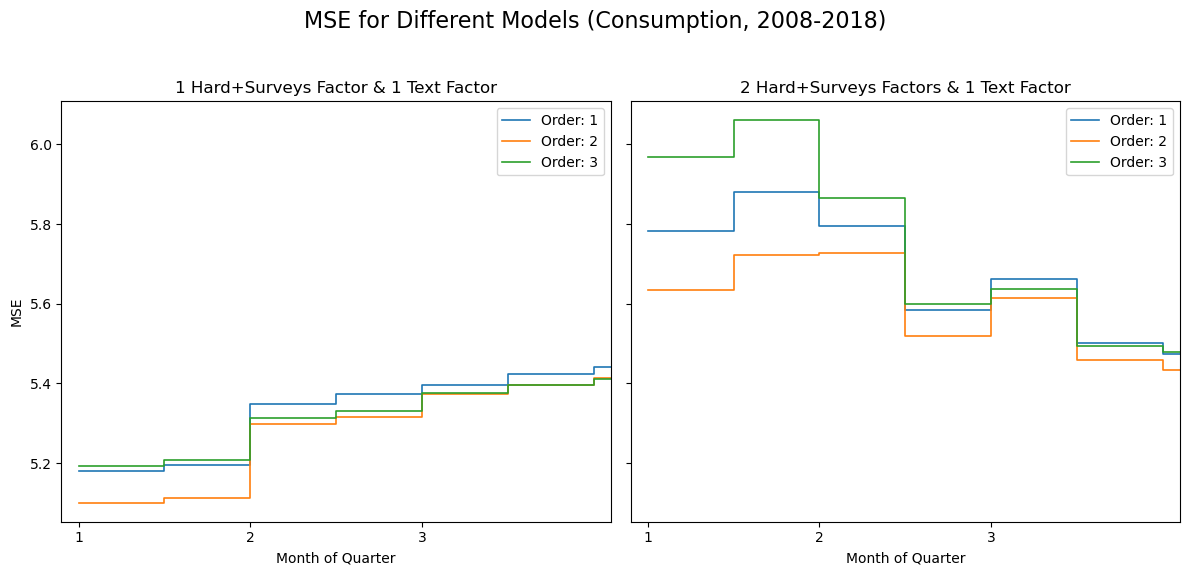

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


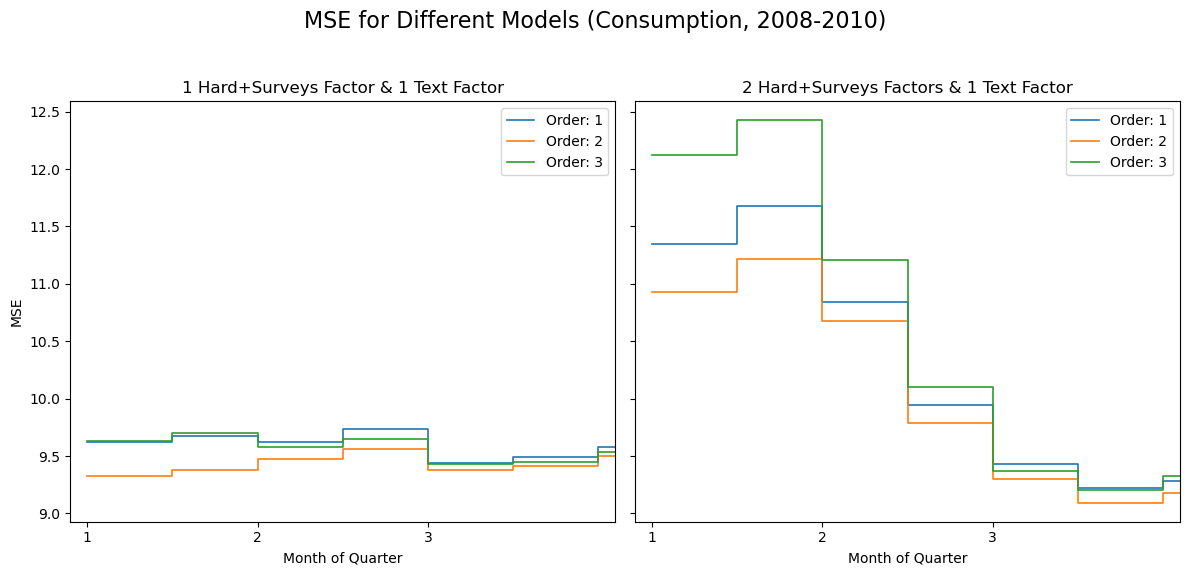

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


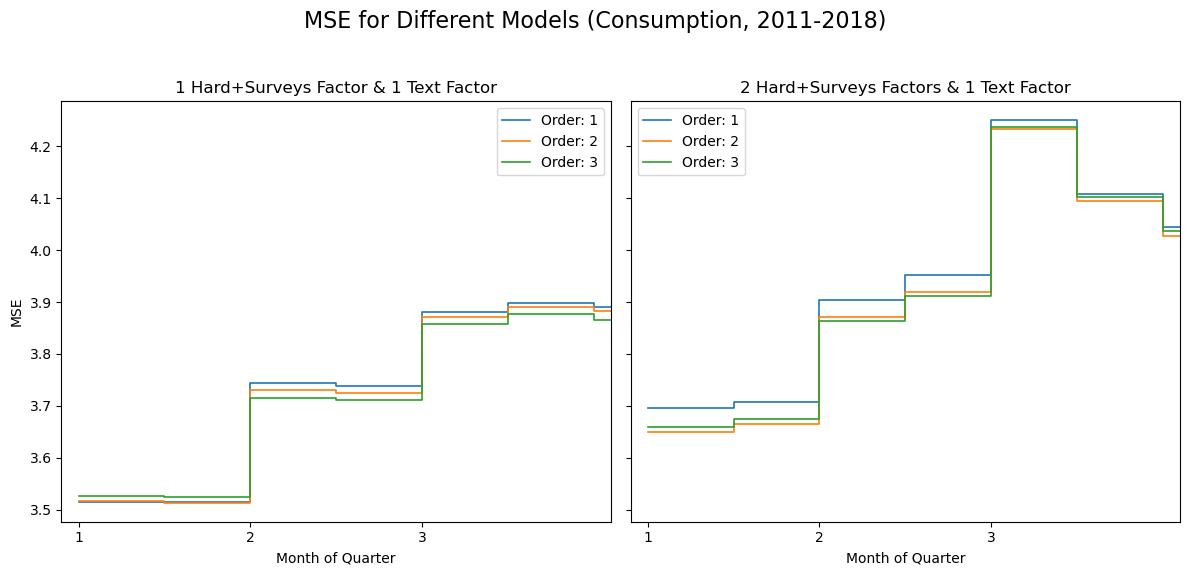

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


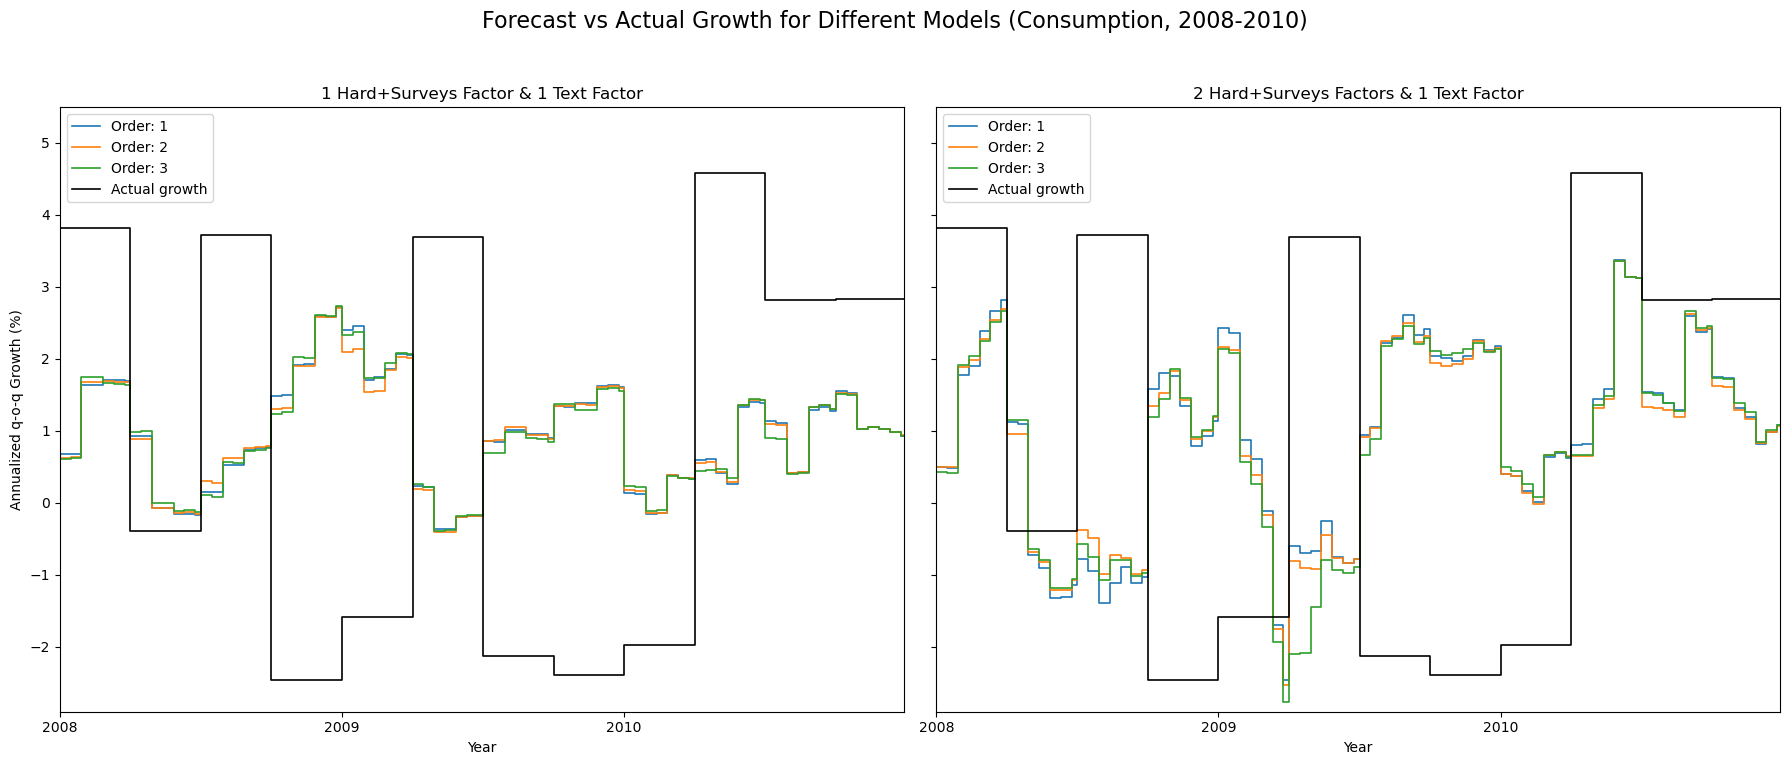

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


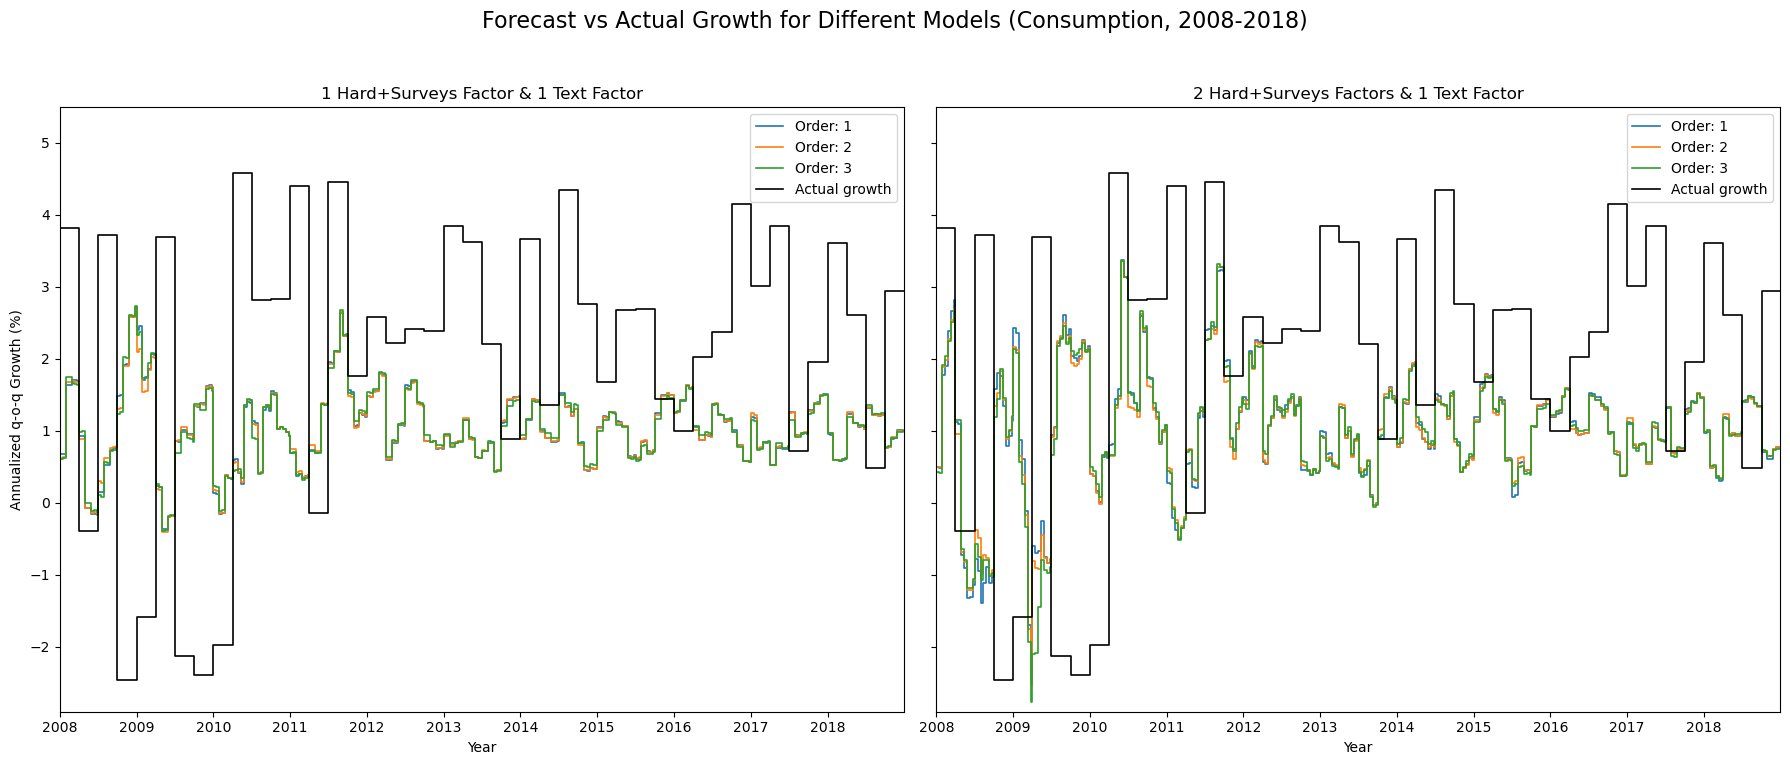

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


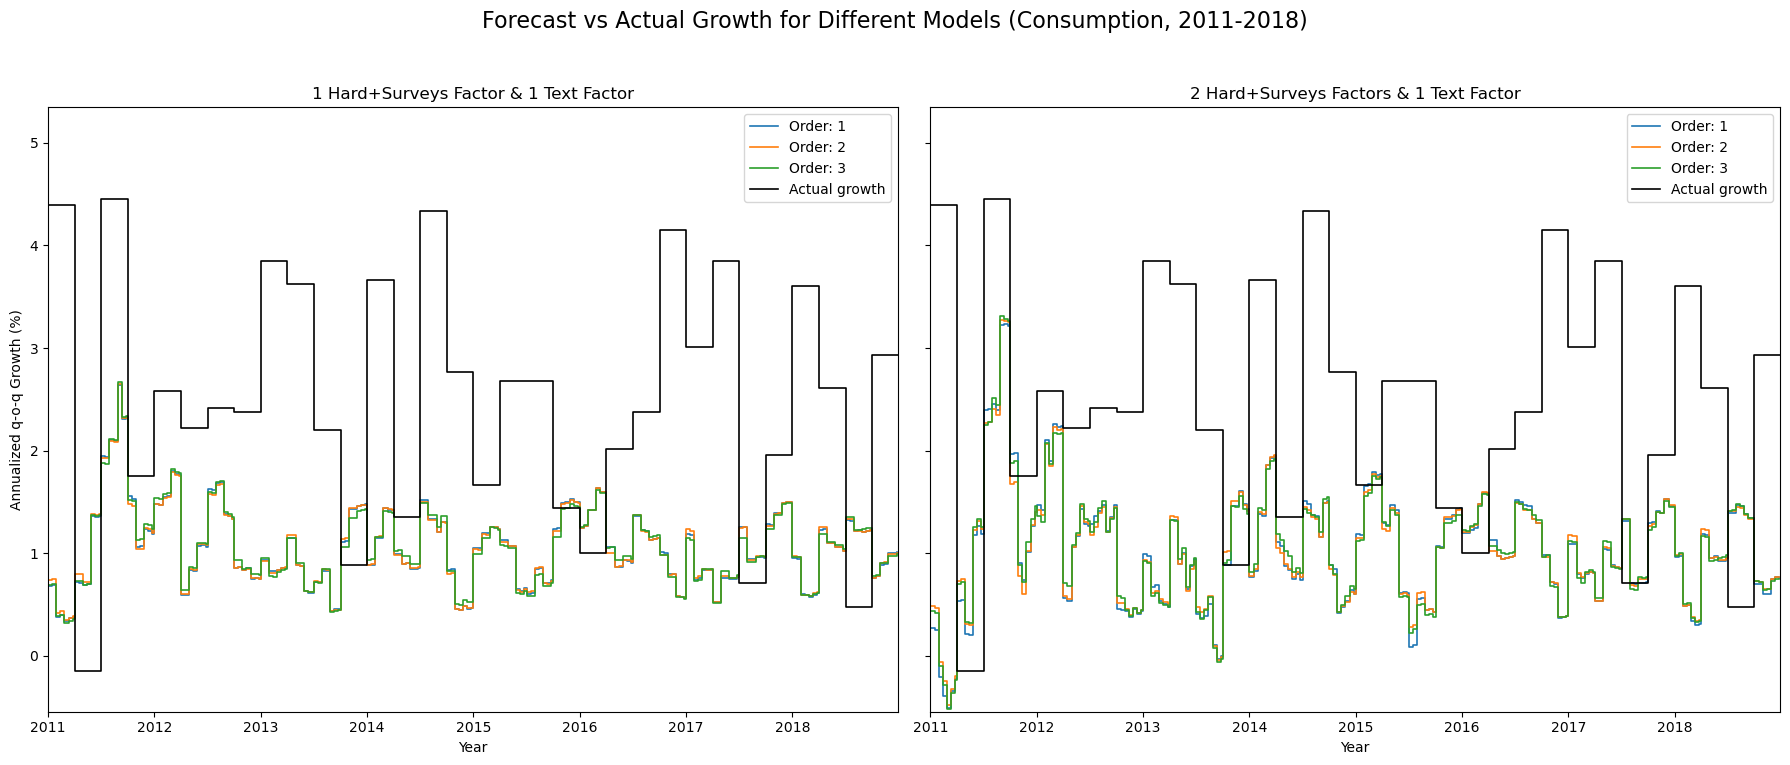

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_sentiws"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()